# Anomaly Detection

### Import libaries used
- **Note**: Ensure that the **path** of 'eco-tools' is configured to your computer

In [1]:
import pandas as pd
import numpy as np
import sys
import os
cwd = os.getcwd()
config_path = cwd + '/src/config/lstmconfig.ini'
import configparser
config = configparser.ConfigParser()
config.read(config_path)
#eco_tools_path = config['SETUP']['eco_tools_path']
#sys.path.append(eco_tools_path)
from src._pi_client import PiClient
#from ecotools.pi_client import pi_client
pc = PiClient(root = 'readonly')
from src.data_helper import *
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### Find point to train on
- **Note**: Esure that only **ONE** point will be used

In [2]:
#search for point 
point = pc.search_by_point('*Wellman_Kerr_Electricity_Demand_kBtu')
point

['Wellman_Kerr_Electricity_Demand_kBtu']

### Set Data Parameters
- **start**: format `'YYYY-MM-DD'`
- **end**: format `'YYYY-MM-DD'` or `'*'` for up to time now
- **interval**: can be `'1h'` - `'nh'` where **n** is any number of hour intervals, can also use `'m'` for minutes or `'s'` for seconds
- **calculation**: preferred method is `'summary'`

In [3]:
start = '2018-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

## Pull the point's data from PI using eco-tools

**`print_report()`**

-------
Generates report of the percentage of NaN values in the data as well as the number of points that are NaN

**parameters**: 

`df`**-**  pandas `DataFrame` generated by the `get_stream_by_point`

`show_plot`**-** `bool` whether to show the data retrieved from PI

`separate_plots`**-** `bool` if several points where passed and want to see each point in it's own plot

**returns**:
-`None`


Grabbing WebIDs ...
WebID collection complete!
13:54:47: Sending API request... Chunk 1 of 1
13:54:48: Response recieved for 1 tags! (0.62)


Column                              |Percent NaN | Rows NaN/Total Rows
----------------------------------------------------------------------
Wellman_Kerr_Electricity_Demand_kBtu|  0.03 %    | 5/14963


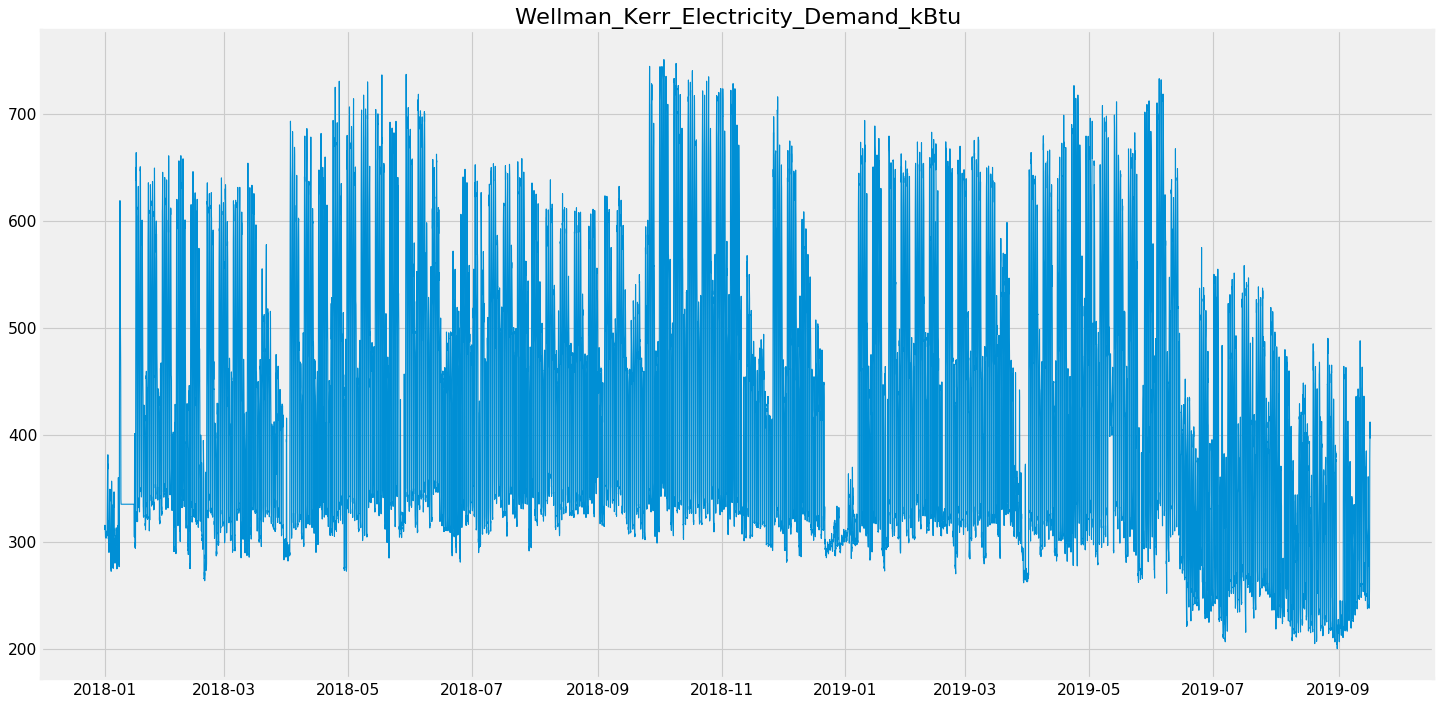

In [4]:
df = pc.get_stream_by_point(point[0], start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

In [5]:
df.dropna(inplace = True)

In [6]:
# figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(df.index, df[point[0]], linewidth = 1)

In [7]:
# df.loc[df[point[0]].isna()]

## Load arguments to create model and remove anomalies

In [8]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #can be either 'LSTM' or 'Random Forest' or None 
    'model_type': 'LSTM',
    
    'epochs' :'default',
################################### Data Pre-processing ################################ 
    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,
    
    #determine if user wants the data to be cleaned prior to model generation 
    'clean_data': True,
    #rolling mean window size
    'days' : 9,
    #iqr multiplier
    'upper_multiplier': 6,
    'lower_multiplier': 1.5,
    
    #clean_type can be either 'value' (any points below or above a threshold will be cut out)
    # or 'iqr' (interquantile range)
    'clean_type': 'rolling_mean',

    
    # if clean_type is IQR then determine the IQR to cut at, an int or float value (ie. 1.5 or 2)
    #if clean is 'value' then pass the value  or a list as shown below
    #if values the threshold =  [lower_bound, upper_bound] (ie. [1200, 3500])
    'threshold': 3.5,
    
    #This will determine if the user wants to see the plot in which the cutoff value(s) are shown 
    'show_cutoff_plot': True,
    
    #This will show if the user wants to see the plot with the cleaned training data and test data combined
    'show_cleaned_plot': True,
    
    #determine what method to use when cleaning the data: 'bfill' (back fill) or 'ffill' (foward fill)  
    'method': 'bfill',
    
########################################### Model Specific Parameters ###################    
    
    #determine if model should train on residuals or the normal data, if None
    'train_on_residuals': True,
    
    #For LSTM only,this will generate the plot of the nueral network's validation and mae loss as a function of epochs
    'show_training_plot' : False,
    
    #show the plots of Training (Modeled vs Actual) and Testing (Modeled vs Actual) plots
    'show_results_plots' : True,
    
##################################################### Anomalies #######################
   
    #This will determine if the user wants to see the plot with the anomalies
    'show_anomalies_plot': True,
    
    #This will deteremine if the user wants to see a plot with the removed anomalies
    'show_removed_anomalies_plot': True
    
    

}
check_kwargs(kwargs)

'Good values!'

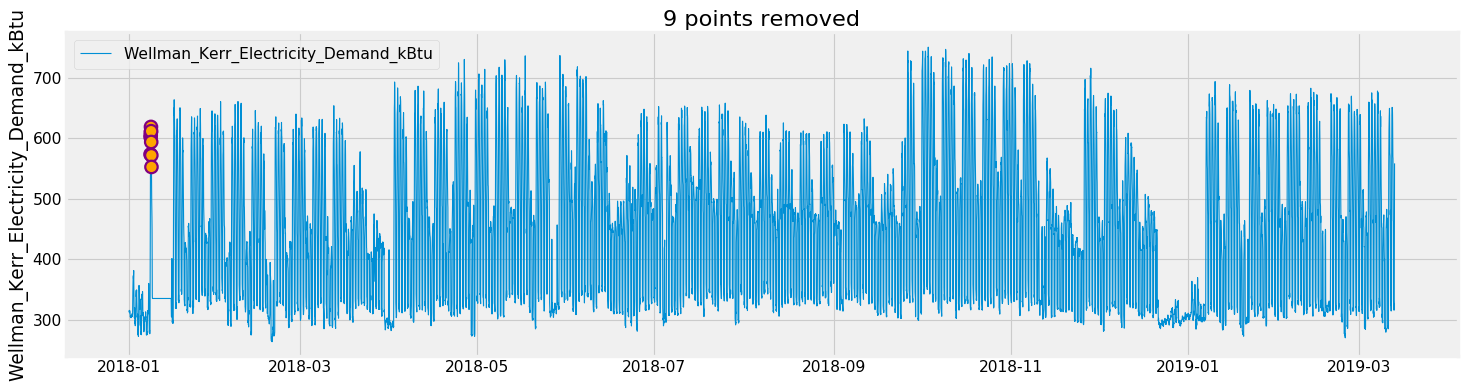

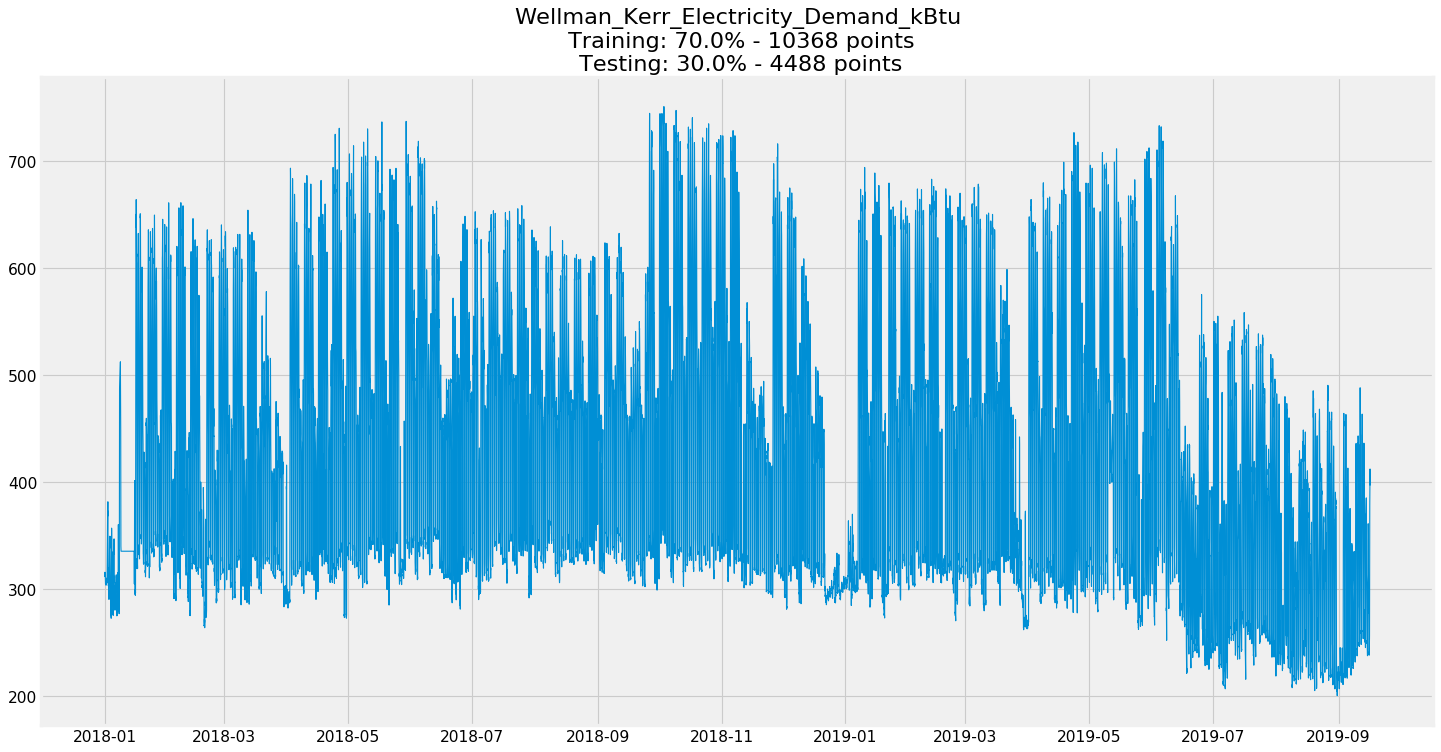

In [9]:
if kwargs['model_type'] is not None:
    df1 = split_and_clean(df, kwargs)

In [10]:
df.head()

,Wellman_Kerr_Electricity_Demand_kBtu
Timestamp,
2018-01-01 00:00:00,312.510161
2018-01-01 01:00:00,315.234447
2018-01-01 02:00:00,315.164660
2018-01-01 03:00:00,311.382525
2018-01-01 04:00:00,315.399647


### Showing Decoposed Data (optional)
If user wants to see decomposed data then uncomment following line of code

In [11]:
#plot_decomposed_data(df1[point[0]], kwargs)

## Creating the Model based on arguments passed

The scrip will generate either an `LSTM`, `Random Forest` or `None` based on arguments passed and will generate plots if user determines

Using TensorFlow backend.


Grabbing WebIDs ...
WebID collection complete!
13:54:53: Sending API request... Chunk 1 of 1
13:54:55: Response recieved for 3 tags! (2.52)
Removed: 0 rows
Train on 10475 samples, validate on 4490 samples
Epoch 1/10
10475/10475 [==============================] - 3s 296us/step - loss: 0.1291 - val_loss: 0.0240
Epoch 2/10
10475/10475 [==============================] - 2s 153us/step - loss: 0.0186 - val_loss: 0.0196
Epoch 3/10
10475/10475 [==============================] - 2s 151us/step - loss: 0.0147 - val_loss: 0.0150
Epoch 4/10
10475/10475 [==============================] - 2s 160us/step - loss: 0.0104 - val_loss: 0.0106
Epoch 5/10
10475/10475 [==============================] - 2s 164us/step - loss: 0.0075 - val_loss: 0.0088
Epoch 6/10
10475/10475 [==============================] - 2s 164us/step - loss: 0.0067 - val_loss: 0.0086
Epoch 7/10
10475/10475 [==============================] - 2s 164us/step - loss: 0.0065 - val_loss: 0.0084
Epoch 8/10
10475/10475 [=============================

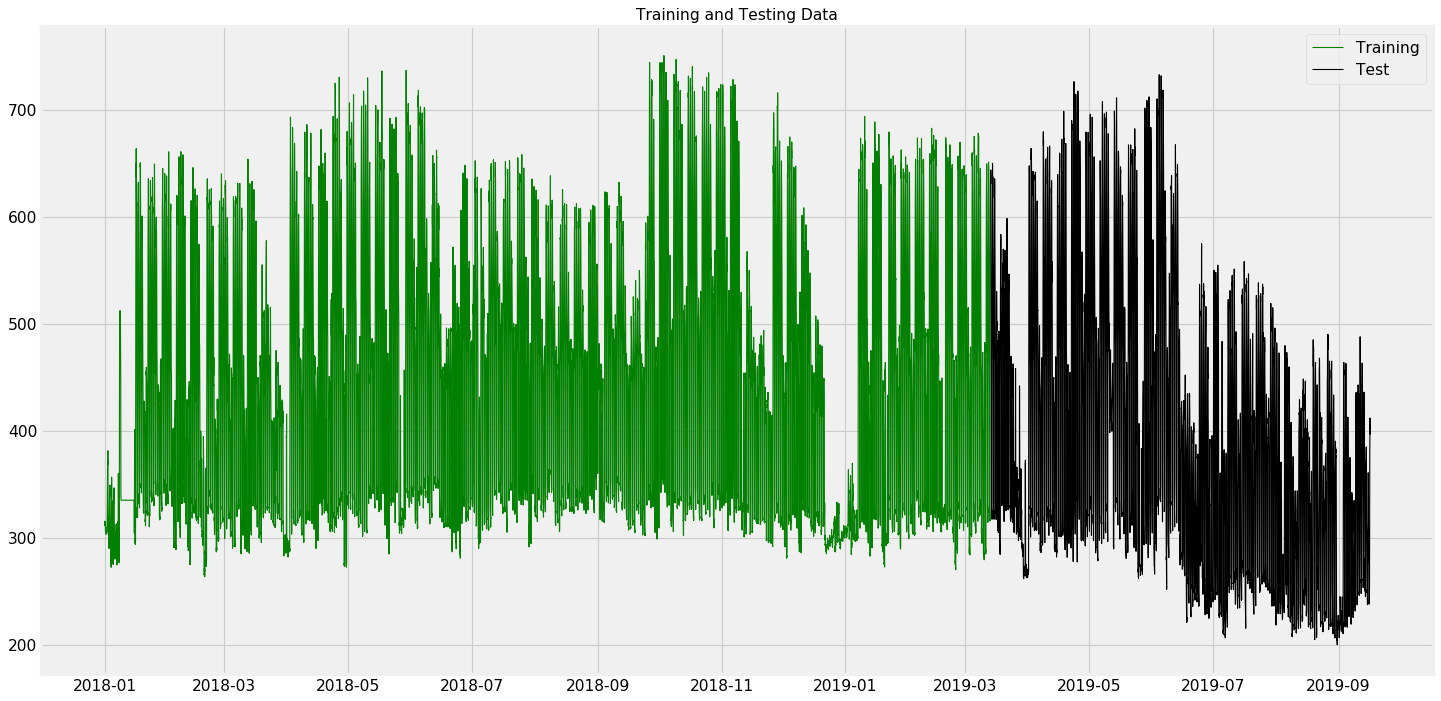

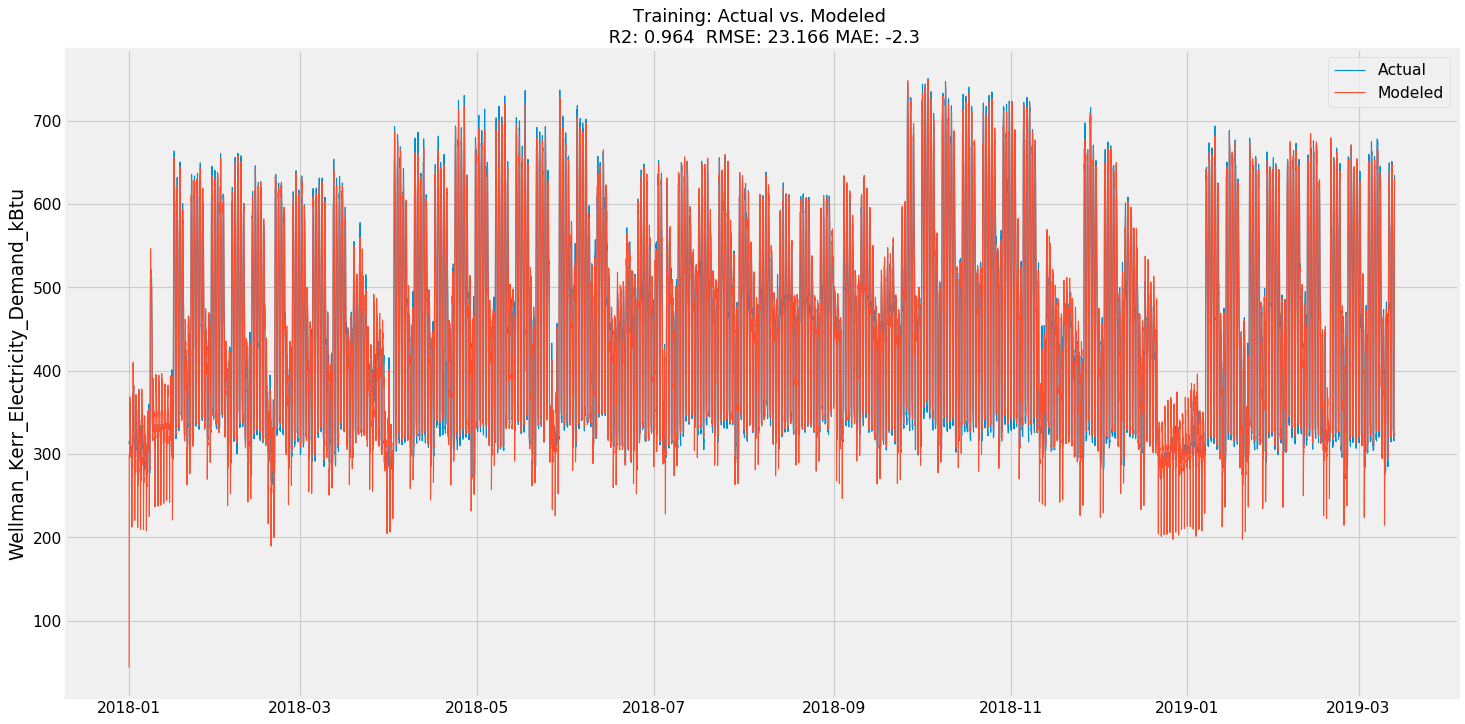

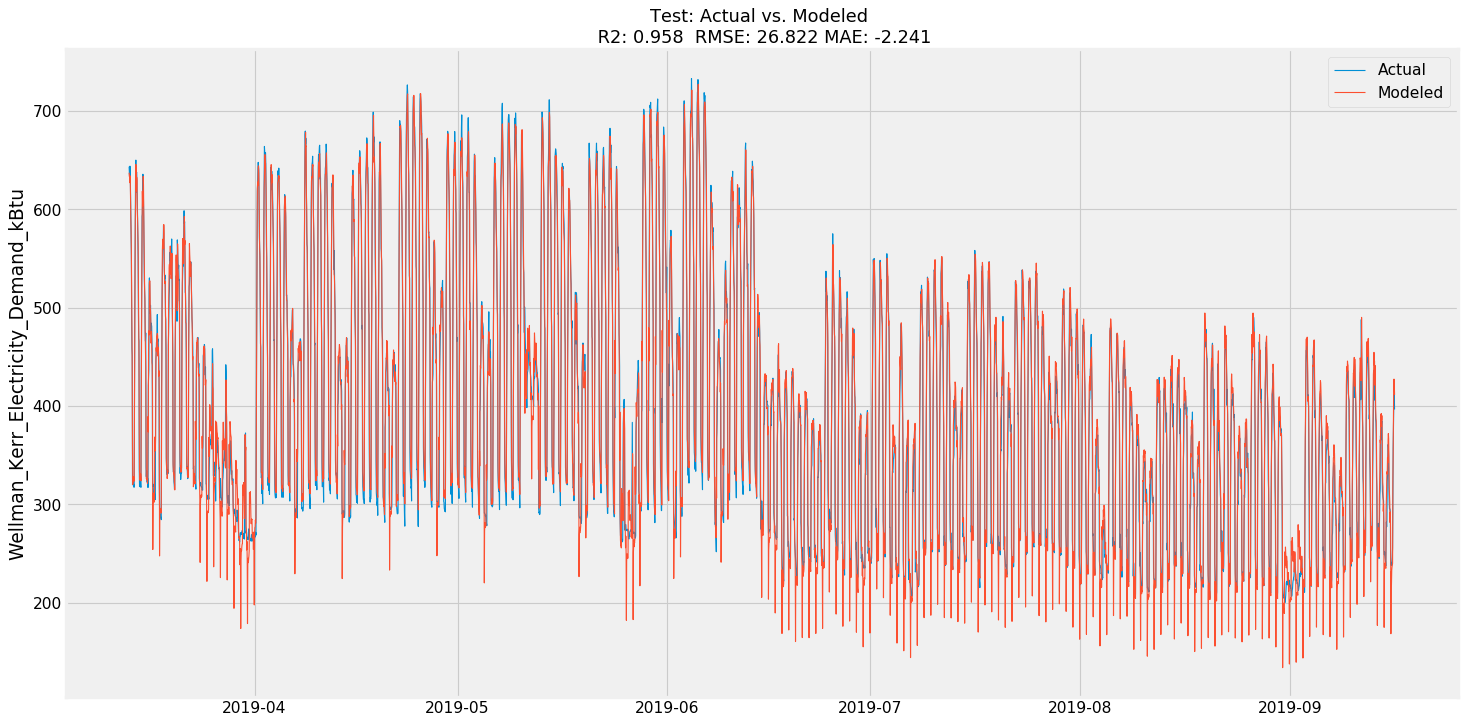

In [12]:
kwargs.update({'epochs':10})
from src.model_generator import *

if kwargs['model_type'] is not None:
    train_df, test_df = create_model(df1, kwargs)
else:
    df3 = create_model(df, kwargs)
    test_df = df3.copy()
    del df3

In [13]:
test_df.eval('Result=Modeled-Actual', inplace = True)
test_df.head()

,Actual,Modeled,Result
Timestamp,,,
2019-03-13 11:00:00,643.210683,637.078907,-6.131776
2019-03-13 12:00:00,636.488358,633.255735,-3.232623
2019-03-13 13:00:00,630.906565,634.374599,3.468034
2019-03-13 14:00:00,643.718714,626.905249,-16.813466
2019-03-13 15:00:00,639.112775,633.528944,-5.583831


In [14]:
days = 9
odd  = True if days % 2 == 1 else False
shift_multiplier = int(days/2) if odd else int(days/2)-1

q75 = test_df.Result.rolling(24*days).quantile(0.75).shift(-(24*shift_multiplier))
q25 = test_df.Result.rolling(24*days).quantile(0.25).shift(-(24*shift_multiplier))
iqr = q75 - q25
upper_threshold = q75 + 3*iqr
lower_threshold = q25 - 3*iqr

upper_threshold.fillna(method = 'bfill', inplace = True)
upper_threshold.fillna(method = 'ffill', inplace = True)
lower_threshold.fillna(method = 'bfill', inplace = True)
lower_threshold.fillna(method = 'ffill', inplace = True)

bad_upper = test_df.loc[test_df.Result > upper_threshold][['Actual']]
s1 = [20 * 25 for n in range(len(bad_upper.index))]

bad_lower = test_df.loc[test_df.Result < lower_threshold][['Actual']]
s2 = [20 * 25 for n in range(len(bad_lower.index))]

points_over_upper = bad_upper.shape[0]
points_below_lower = bad_lower.shape[0]

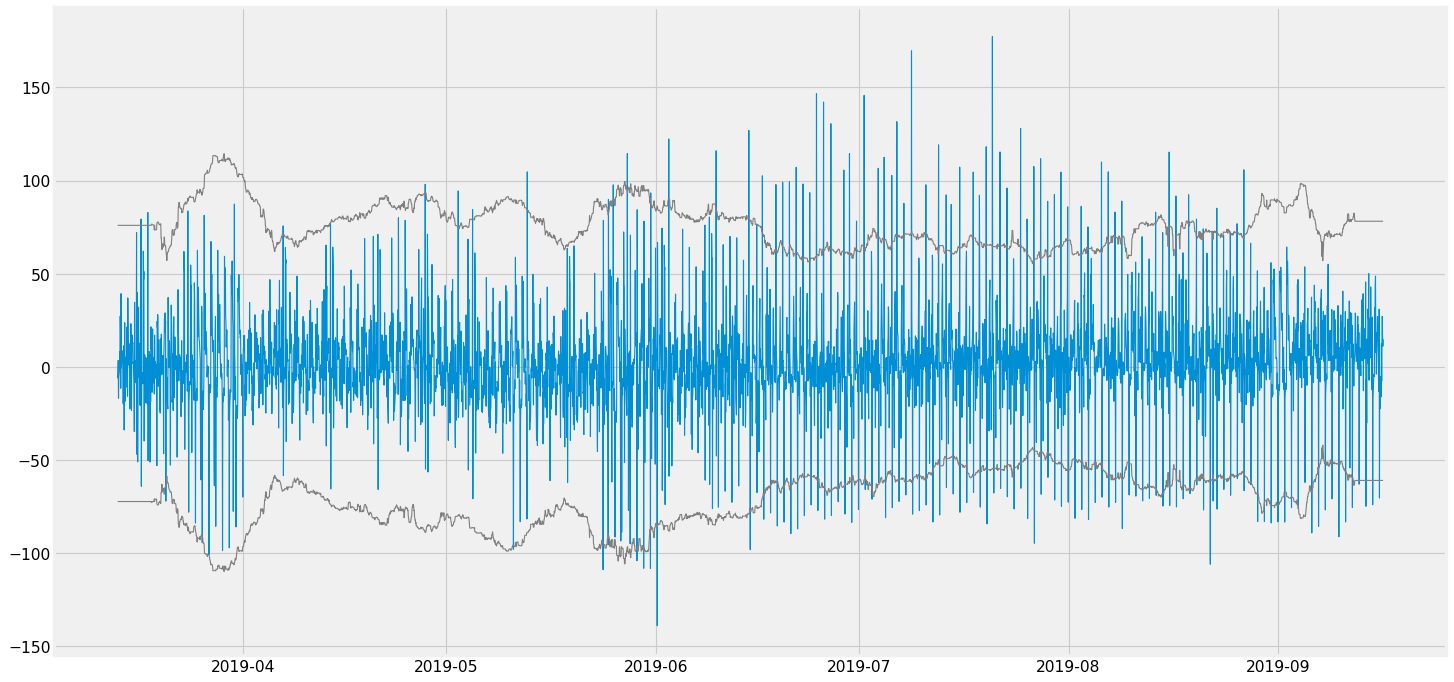

In [15]:
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_df.index, test_df.Result, linewidth= 1)
plt.plot(lower_threshold.index, lower_threshold, linewidth= 1, color = 'gray')
plt.plot(upper_threshold.index, upper_threshold, linewidth= 1., color = 'gray')

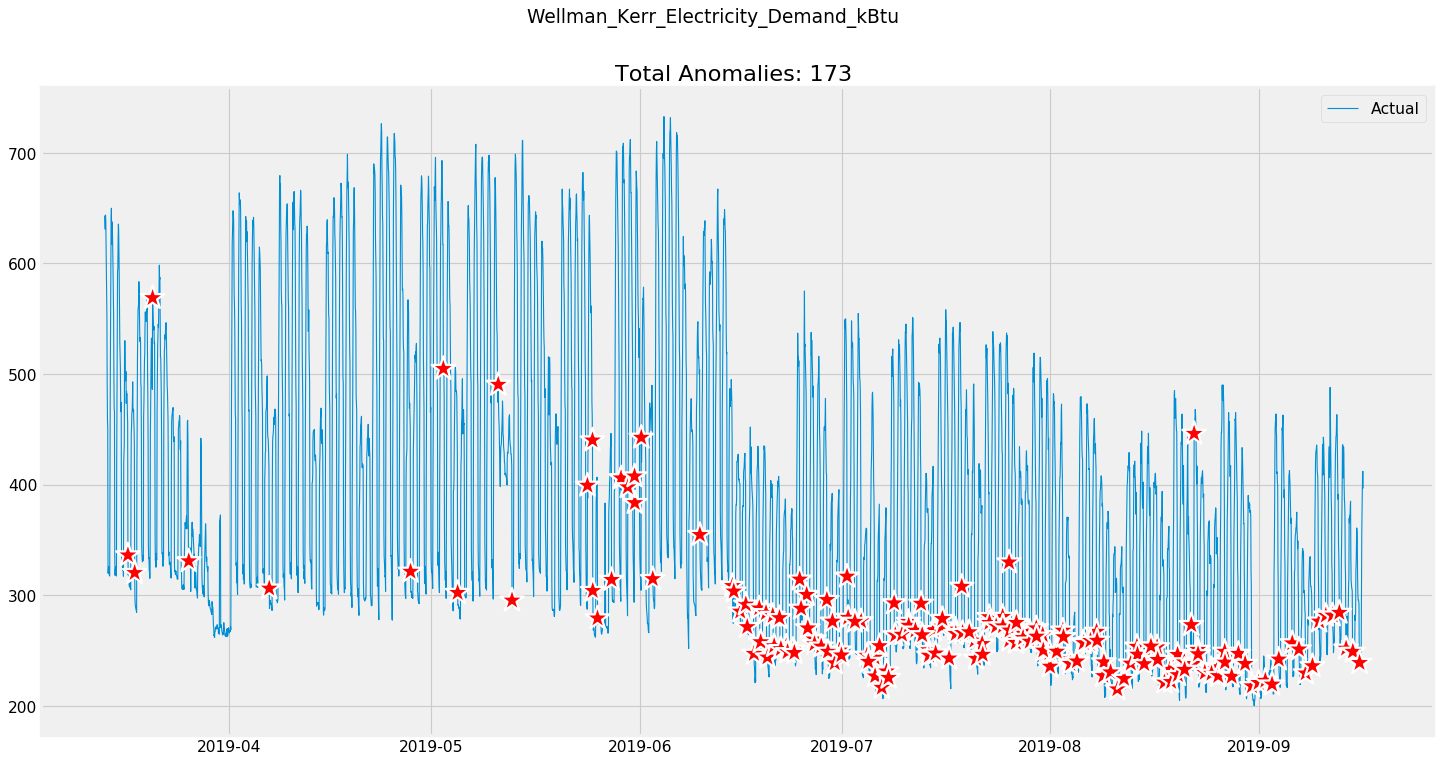

In [16]:
#plt.style.use('fast')
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(test_df.index, test_df.Actual, linewidth= 1, label = "Actual", zorder = 1)

#plt.plot(upper_threshold.index, upper_threshold, linewidth = 1, label = "Upper", color = "red", zorder = 2)
plt.scatter(bad_upper.index, bad_upper, marker = "*", color ="red",linewidth = 2, zorder = 2, s = s1, edgecolors = 'white')

#plt.plot(lower_threshold.index, lower_threshold, linewidth = 1, label = "Lower", color = "black", zorder = 3)
plt.scatter(bad_lower.index, bad_lower, marker = "*", color ="red",linewidth = 2, zorder = 4, s = s2, edgecolors = 'white')

plt.suptitle(point[0])
plt.title(f"Total Anomalies: {points_over_upper + points_below_lower} ")
plt.legend()

## Finding Anomalies
This method creates a datframe with Results = Actual - Modeled and uses either *interquantile range* or *standard deviation* to find anomalies.

`args`: Can be either `'iqr'` (inter quantile range)  `'sd'` (standard deviation) with their respective thresholds , or `'percent'` which is the percent error in modeled and actual data. 

**Note** `percent` only to be used with data that has used a model to train on.

**ex1.** `{'anomalies_method': {'iqr': 7.5}  }`

**ex2.** `{'anomalies_method': {'sd': 3}  }`

**ex3.** `{'anomalies_method': {'percent' : 10.0} }`


In [17]:

args = {'anomalies_method': 
                    {'iqr': 4.0}  }

check_args(args, kwargs['model_type'])

"Good 'arg' values!"

25:-8.117140120221634, 75:13.193930917927474
 iqr: 21.31107103814911 
 up: 98.43821507052391 lo: -93.36142427281807


<Figure size 1600x800 with 0 Axes>

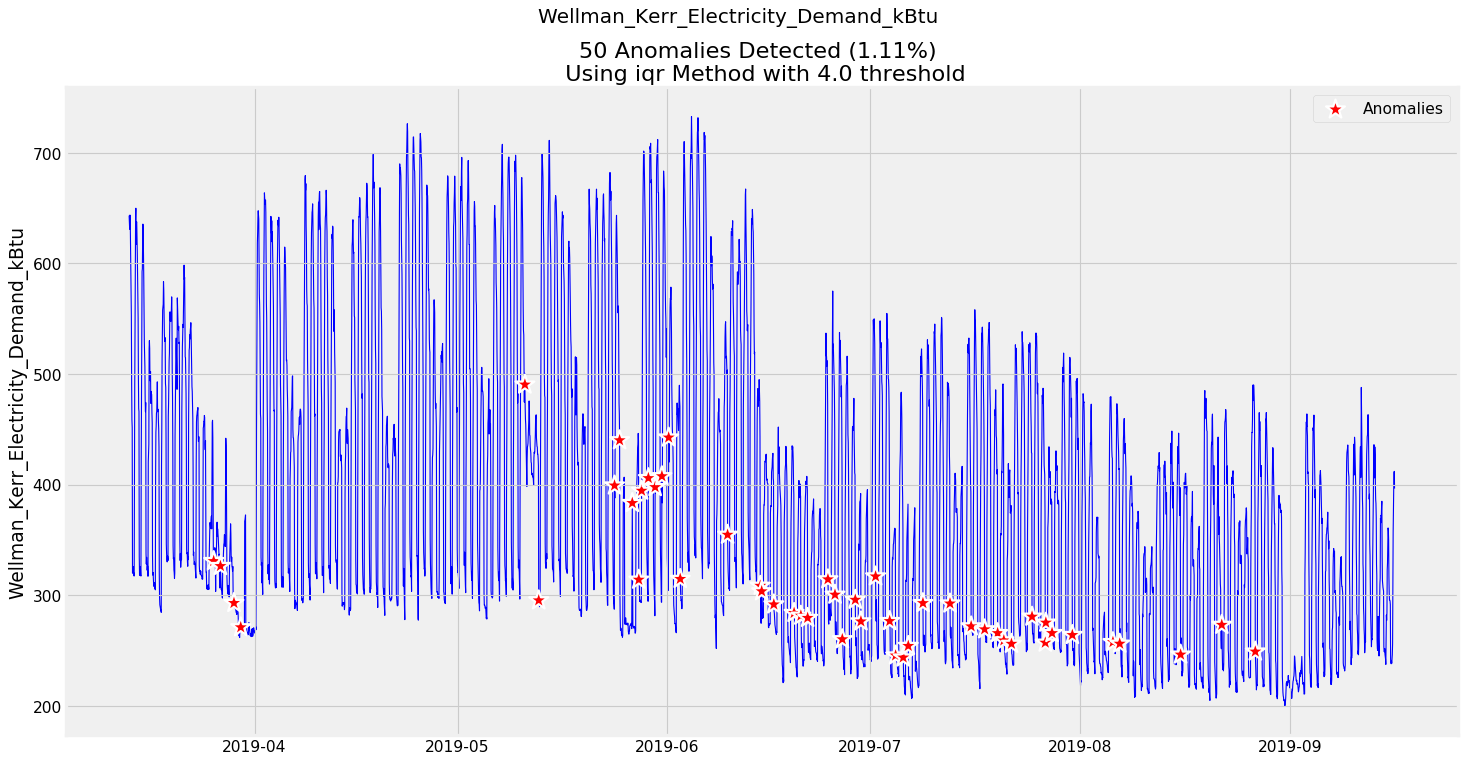

In [18]:
a_df = find_anomalies(test_df,args = args, kwargs = kwargs)

## Remove anomalies from dataset

**Returns**: a `DataFrame` with anomalies removed from the dataset


Number of Points (pre clean): 4490
Removing 50 anomalies...
Number of Points (post clean): 4440


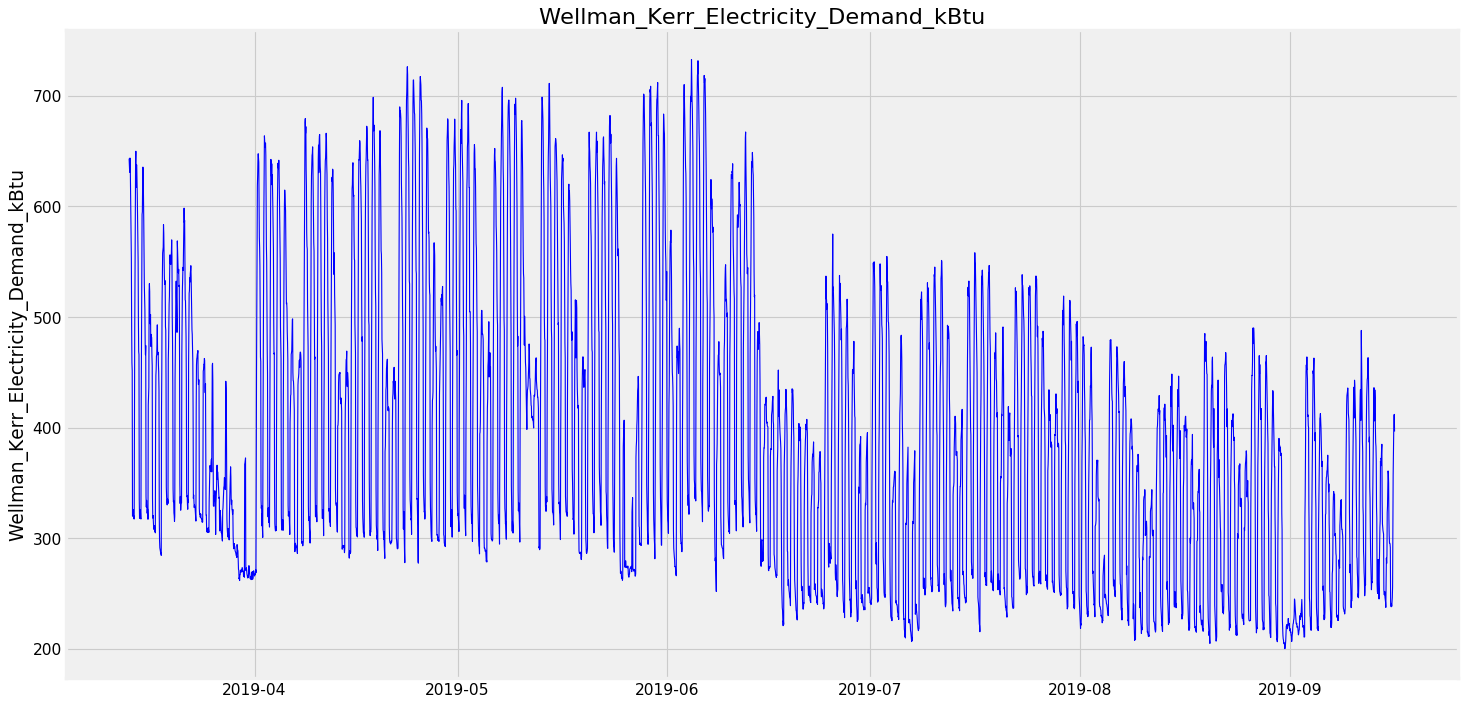

In [19]:
cleaned_df = drop_anomalies(a_df, kwargs)

## Save Data (optional)

The following code cell will save the `DataFrame` that has the anomalies tagged

The columns are: `Actual`, `Modeled`, `Anomalies` and `Result`


In [20]:

# from datetime import datetime
# date = datetime.today().strftime('%Y%m%d')
# point_name = kwargs['point']
# a_df.to_csv(f"{point_name}_Anomalies_{date}.csv")